In [ ]:
!pip install fastai --upgrade
!pip install fastbook

In [30]:
from fastai.vision.all import *
from fastbook import *

In [9]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [11]:
Path.BASE_PATH = path
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

Using my get_image_files to create a variable with all of my stored images rather than both txts and jpgs. Since BIWI dataset had both

In [19]:
img_files = get_image_files(path)
def imgToPose(x): return Path(f'{str(x)[:-7]}pose.txt') #transforming our .jpg to .txts
imgToPose(img_files[0])

Path('11/frame_00437_pose.txt')

Creating a PIL image from our variable. A PIL is a image file that allows for manipulation in Python

In [20]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

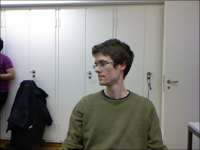

In [22]:
im.to_thumb(200)

This next function is given by the BIWI data set on how to find the center point. Nothing to learn from here. THIS IS GIVEN

In [26]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer = 6)
def get_ctr(f):
  ctr = np.genfromtxt(imgToPose(f), skip_header = 3)
  c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
  c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
  return tensor([c1,c2])

In [28]:
get_ctr(img_files[0])

tensor([341.0537, 213.9402])

In [35]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items = get_image_files,
    get_y = get_ctr,
    splitter = FuncSplitter(lambda o: o.parent.name == '13'),
    batch_tfms = [*aug_transforms(size = (240,320)), Normalize.from_stats(*imagenet_stats)]
)

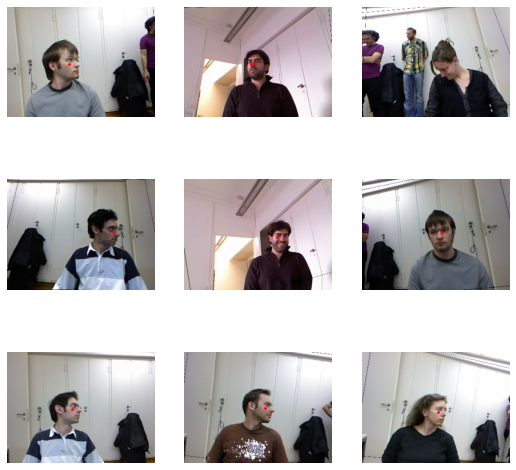

In [38]:
dls = biwi.dataloaders(path)
dls.show_batch()

In [39]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [40]:
learn = cnn_learner(dls, resnet34, y_range=(-1,1))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Using the LRFinder, we choose 1e-2 because it is our steepest learning

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.03981071710586548)

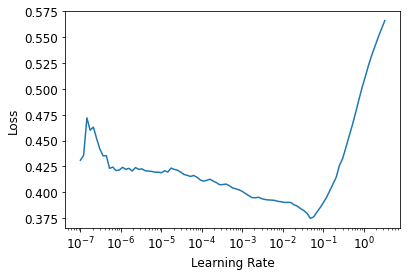

In [41]:
learn.lr_find()

In [42]:
lr = 1e-2
learn.fine_tune(3,lr)

epoch,train_loss,valid_loss,time
0,0.046500,0.004897,02:23


epoch,train_loss,valid_loss,time
0,0.006390,0.001111,03:08
1,0.002885,0.000172,03:08
2,0.001407,0.000075,03:08


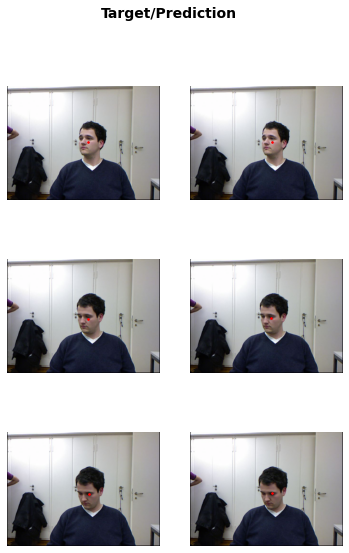

In [43]:
learn.show_results()

As we see here, our model is extremely accurate at detecting the middle point of our images. 